In [1]:
import scipy.optimize as opt
import numpy as np
import matplotlib.pyplot as plt


In [2]:
### foil data from Alignment runs with 1 and 8 pulses per spill, for each of the isotopes
xy=np.array([[0,0],
             [7,7],
             [7,-7],
             [-7,-7],
             [-7,7]
            ])


### Data counts assume mislabelling of the counts for Be-8 and Na-22 for the 8 pulse foils
##   A->D
##   B->C
##   C->B
##   D->A
##   E->E
# With this, relative counts make much more sense

DataCounts={'Na24_8pulse':[216000,115000,76100,51400,89000],
            'Na22_8pulse' : [192,96,71,42.9,67],
            'Be7_8pulse'  : [820,445,257,186,344],
            'Na24_1pulse':[235000,124000,76900,45000,109000],
            'Na22_1pulse' : [194,97,70,47.9,78],
            'Be7_1pulse'  : [880,429,241,224,389],
           }
DataUnc   ={'Na24_8pulse':[28000,15000,9800,6600,11000],
            'Na22_8pulse' : [26,14,10,6.9,10],
            'Be7_8pulse'  : [110,67,44,36,53],
            'Na24_1pulse':[30000,16000,9900,5800,14000],
            'Na22_1pulse' : [26,14,10,8,12],
            'Be7_1pulse'  : [120,64,43,39,59],
           }


FullXY=[]
FullData=[]
FullUnc=[]
for k,i in DataCounts.items():
    FullXY.append(xy)
    FullData.append(DataCounts[k])
    FullUnc.append(DataUnc[k])
    
FullXY=np.array(FullXY)
for i in range(6):
    FullXY[i,:,0] += 100*i
FullXY=FullXY.reshape(30,2)
FullData=np.array(FullData).flatten()
FullUnc=np.array(FullUnc).flatten()

In [3]:
#beam fit function modified from 
#https://stackoverflow.com/questions/21566379/fitting-a-2d-gaussian-function-using-scipy-optimize-curve-fit-valueerror-and-m

def twoD_Gaussian(xy, amplitude, xo, yo, sigma_x, sigma_y):
    theta=0
    x=xy[:,0]
    y=xy[:,1]
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()


def simultaneousFit_twoD_Gaussian_3(xy, amp1, amp2, amp3, xo, yo, sigma_x, sigma_y):
    """fit function, containing 3 2d gaussians, offset by 100mm in x, to fit 3 measurements at once"""
    x=xy[:,0]
    y=xy[:,1]
    b = 1/(2*sigma_x**2)
    c = 1/(2*sigma_y**2)
    g = (amp1*np.exp( - (b*(( 0 +x-xo)**2)+ c*((y-yo)**2))) + 
         amp2*np.exp( - (b*((100+x-xo)**2)+ c*((y-yo)**2))) + 
         amp3*np.exp( - (b*((200+x-xo)**2)+ c*((y-yo)**2))) 
        )
    
    return g.ravel()



def simultaneousFit_twoD_Gaussian_6(xy, amp1, amp2, amp3, amp4, amp5, amp6, xo, yo, sigma_x, sigma_y):
    """
    Fit function, containing 6 2d gaussians, offset by 100mm in x, to fit all 6 measurements at once
    Assumes same beam properties for each, with separate amplitudes
    """
    x=xy[:,0]
    y=xy[:,1]
    b = 1/(2*sigma_x**2)
    c = 1/(2*sigma_y**2)
    g = (amp1*np.exp( - (b*(( 0 +x-xo)**2)+ c*((y-yo)**2))) + 
         amp2*np.exp( - (b*((100+x-xo)**2)+ c*((y-yo)**2))) + 
         amp3*np.exp( - (b*((200+x-xo)**2)+ c*((y-yo)**2))) + 
         amp4*np.exp( - (b*((300+x-xo)**2)+ c*((y-yo)**2))) + 
         amp5*np.exp( - (b*((400+x-xo)**2)+ c*((y-yo)**2))) + 
         amp6*np.exp( - (b*((500+x-xo)**2)+ c*((y-yo)**2)))
        )
    
    return g.ravel()


def simultaneousFit_twoD_Gaussian_6_ratio(xy, amp1, amp2, amp3, amp4, amp5, amp6, xo, yo, sigma):
    """
    Fit function, containing 6 2d gaussians, offset by 100mm in x, to fit all 6 measurements at once
    Assumes same beam properties for each, with separate amplitudes
    Constrain the ratio of sigma_X and sigma_Y
    """
    x=xy[:,0]
    y=xy[:,1]
    
    sigma_x=sigma
    sigma_y=sigma/2.3
    
    b = 1/(2*sigma_x**2)
    c = 1/(2*sigma_y**2)
    g = (amp1*np.exp( - (b*(( 0 +x-xo)**2)+ c*((y-yo)**2))) + 
         amp2*np.exp( - (b*((100+x-xo)**2)+ c*((y-yo)**2))) + 
         amp3*np.exp( - (b*((200+x-xo)**2)+ c*((y-yo)**2))) + 
         amp4*np.exp( - (b*((300+x-xo)**2)+ c*((y-yo)**2))) + 
         amp5*np.exp( - (b*((400+x-xo)**2)+ c*((y-yo)**2))) + 
         amp6*np.exp( - (b*((500+x-xo)**2)+ c*((y-yo)**2)))
        )
    
    return g.ravel()




In [4]:
fitVals=[]
fitCov=[]

print('Individual Fit Results')
print()
for key,data in DataCounts.items():
    print(key)
    unc=DataUnc[key]
    popt,pcov=opt.curve_fit(lambda xy, a, xo, yo, sx, sy: twoD_Gaussian(xy, a, xo, yo, sx, sy), xy, data, sigma=unc,p0=(data[0],0,0,10,10),bounds=((0,-10,-10,0,0),(np.inf,10,10,30,30)))
    print('[x_0        y_0        sigma_x    sigma_y   ]')
    print(popt[1:])
    print()
    fitVals.append(popt)
    fitCov.append(pcov)
fitVals=np.array(fitVals)
fitCov=np.array(fitCov)


Individual Fit Results

Na24_8pulse
[x_0        y_0        sigma_x    sigma_y   ]
[1.56091552 1.5611604  8.36300131 6.80338186]

Na22_8pulse
[x_0        y_0        sigma_x    sigma_y   ]
[1.38355147 1.25080892 6.70703726 6.89634407]

Be7_8pulse
[x_0        y_0        sigma_x    sigma_y   ]
[1.06964601 1.79590209 7.25419643 6.5865794 ]

Na24_1pulse
[x_0        y_0        sigma_x    sigma_y   ]
[1.92568981 1.92652025 9.22994454 6.36398297]

Na22_1pulse
[x_0        y_0        sigma_x    sigma_y   ]
[1.02061599 1.40008909 6.94265284 7.01576111]

Be7_1pulse
[x_0        y_0        sigma_x    sigma_y   ]
[0.34798572 1.61962434 7.4635828  6.33924922]



/Users/dnoonan/Library/Python/3.8/lib/python/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [5]:
p0=[FullData[0],
    FullData[5],
    FullData[10],
    FullData[15],
    FullData[20],
    FullData[25],
    0,0,5,5]

bounds=((0,0,0,0,0,0,-10,-10,0,0),
        (np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,10,10,30,30))
    
popt,pcov=opt.curve_fit(simultaneousFit_twoD_Gaussian_6, FullXY, FullData, sigma=FullUnc,p0=p0,bounds=bounds)
print('[x_0        y_0        sigma_x    sigma_y   ]')
print(popt[6:])
print()
print('Covariance Matrix')
print(pcov[6:,6:])

[x_0        y_0        sigma_x    sigma_y   ]
[1.1553956  1.65681634 7.07296797 6.93027438]

Covariance Matrix
[[ 2.34076547e+16 -3.22254532e+16  7.16471440e+16 -6.73977044e+16]
 [-3.22254532e+16  4.43649672e+16 -9.86370362e+16  9.27868082e+16]
 [ 7.16471440e+16 -9.86370362e+16  2.19300622e+17 -2.06293757e+17]
 [-6.73977044e+16  9.27868082e+16 -2.06293757e+17  1.94058338e+17]]


In [6]:
p0=[FullData[0],
    FullData[5],
    FullData[10],
    FullData[15],
    FullData[20],
    FullData[25],
    0,0,5]

bounds=((0,0,0,0,0,0,-10,-10,0),
        (np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,10,10,30))
    
popt,pcov=opt.curve_fit(simultaneousFit_twoD_Gaussian_6_ratio, FullXY, FullData, sigma=FullUnc,p0=p0,bounds=bounds)
print('[ x_0         y_0        sigma_x    ] (sigma_y=sigma_x/2.3)')
print(popt[6:],popt[-1]/2.3)
print()
print('Covariance Matrix')
print(pcov[6:,6:])

[ x_0         y_0        sigma_x    ] (sigma_y=sigma_x/2.3)
[ 3.55962742  1.0050749  12.41484691] 5.397759527486566

Covariance Matrix
[[127.2841933    3.39938693  26.83132285]
 [  3.39938693   5.13351918   7.22875152]
 [ 26.83132285   7.22875152  45.18292653]]


This 2.3 ratio seems more realistic, given the shape of the burn mark
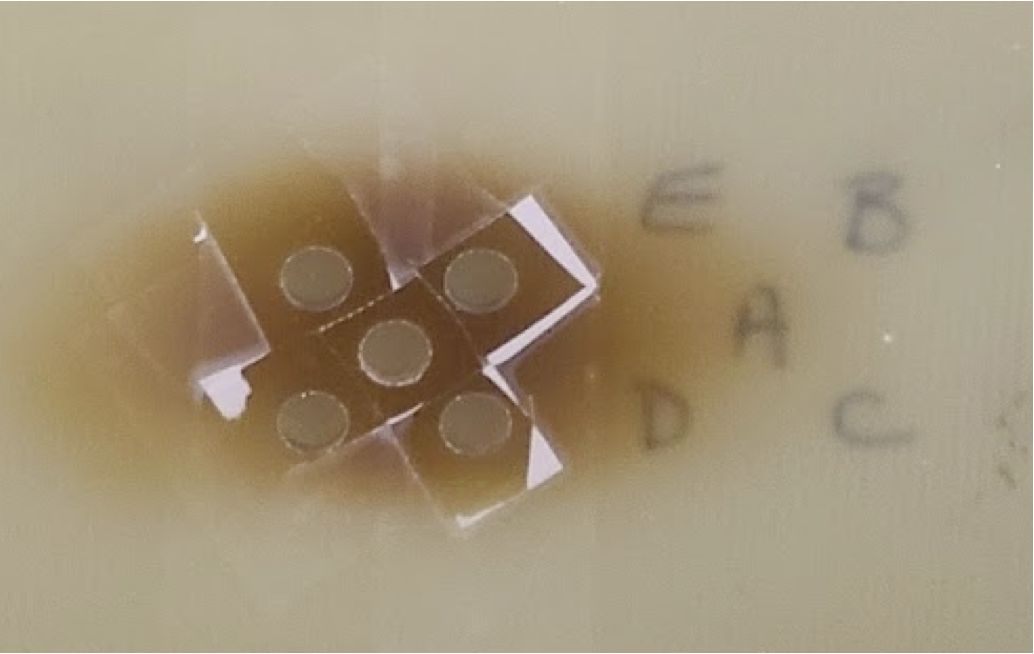